In [1]:
# Basic Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
# Modelling
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

In [2]:
df = pd.read_csv('data/data.csv')
df.head()

,footfall,tempMode,AQ,USS,CS,VOC,RP,IP,Temperature,fail
0,0,7,7,1,6,6,36,3,1,1
1,190,1,3,3,5,1,20,4,1,0
2,31,7,2,2,6,1,24,6,1,0
3,83,4,3,4,5,1,28,6,1,0
4,640,7,5,6,4,0,68,6,1,0


In [4]:
X = df.drop(labels=['tempMode'],axis=1)
Y = df[['tempMode']]

In [10]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(X,Y,test_size=0.2,random_state=0)
xtrain.shape, xtest.shape

((755, 9), (189, 9))

In [11]:
xtrain.head()

,footfall,AQ,USS,CS,VOC,RP,IP,Temperature,fail
181,53,2,3,6,0,57,6,12,0
285,22,5,4,6,5,61,4,15,1
715,55,2,2,6,0,41,3,21,0
299,19,5,1,4,6,68,3,15,1
935,0,6,3,6,6,55,7,24,1


In [12]:
xtest.head()

,footfall,AQ,USS,CS,VOC,RP,IP,Temperature,fail
638,9,7,2,5,4,46,3,20,0
545,64,5,2,6,6,26,5,19,1
688,51,5,2,6,1,41,6,21,0
14,1000,5,7,4,0,74,1,1,0
261,2,6,3,5,5,42,3,14,1


In [13]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

In [14]:
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(), 
    "CatBoosting Regressor": CatBoostRegressor(verbose=False),
    "AdaBoost Regressor": AdaBoostRegressor()
}
model_list = []
r2_list =[]

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(xtrain, ytrain.values.flatten()) # Train model

    # Make predictions
    y_train_pred = model.predict(xtrain)
    y_test_pred = model.predict(xtest)
    
    # Evaluate Train and Test dataset
    model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(ytrain, y_train_pred)

    model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(ytest, y_test_pred)

    
    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    r2_list.append(model_test_r2)
    
    print('='*35)
    print('\n')

Linear Regression
Model performance for Training set
- Root Mean Squared Error: 2.4465
- Mean Absolute Error: 2.0750
- R2 Score: 0.1873
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 2.3952
- Mean Absolute Error: 2.0221
- R2 Score: 0.0902


Lasso
Model performance for Training set
- Root Mean Squared Error: 2.4534
- Mean Absolute Error: 2.0975
- R2 Score: 0.1827
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 2.3891
- Mean Absolute Error: 2.0336
- R2 Score: 0.0949


Ridge
Model performance for Training set
- Root Mean Squared Error: 2.4465
- Mean Absolute Error: 2.0750
- R2 Score: 0.1873
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 2.3953
- Mean Absolute Error: 2.0222
- R2 Score: 0.0902


K-Neighbors Regressor
Model performance for Training set
- Root Mean Squared Error: 2.2012
- Mean Absolute Error: 1.7947
- R2 Score: 0.3421
-----------------------

In [15]:
df_results = pd.DataFrame(list(zip(model_list, r2_list)), columns=['Model Name', 'R2_Score']).sort_values(by=["R2_Score"],ascending=False)
df_results

,Model Name,R2_Score
1,Lasso,0.094896
0,Linear Regression,0.090247
2,Ridge,0.090233
8,AdaBoost Regressor,0.074059
5,Random Forest Regressor,0.008283
7,CatBoosting Regressor,-0.008632
3,K-Neighbors Regressor,-0.094570
6,XGBRegressor,-0.182572
4,Decision Tree,-0.760239


In [16]:
# Initializing catboost
cbr = CatBoostRegressor(verbose=False)

# Creating the hyperparameter grid
param_dist = {'depth'          : [4,5,6,7,8,9, 10],
              'learning_rate' : [0.01,0.02,0.03,0.04],
               'iterations'    : [300,400,500,600]}

#Instantiate RandomSearchCV object
rscv = RandomizedSearchCV(cbr , param_dist, scoring='r2', cv =5, n_jobs=-1)

# Fit the model
rscv.fit(xtrain, ytrain.values.flatten())

# Print the tuned parameters and score
print(rscv.best_params_)
print(rscv.best_score_)

{'learning_rate': 0.01, 'iterations': 600, 'depth': 5}
0.12652913213131928


In [17]:
def print_evaluated_results(model,xtrain,ytrain,xtest,ytest):
    ytrain_pred = model.predict(xtrain)
    ytest_pred = model.predict(xtest)

    # Evaluate Train and Test dataset
    model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(ytrain, ytrain_pred)
    model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(ytest, ytest_pred)

    # Printing results
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))

In [18]:
# Selecting best model
best_cbr = rscv.best_estimator_

# Evaluate Train and Test dataset
print_evaluated_results(best_cbr,xtrain,ytrain,xtest,ytest)

Model performance for Training set
- Root Mean Squared Error: 2.1737
- Mean Absolute Error: 1.8392
- R2 Score: 0.3585
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 2.4014
- Mean Absolute Error: 2.0294
- R2 Score: 0.0856


In [20]:
from sklearn.model_selection import GridSearchCV
# Initialize knn
knn = KNeighborsRegressor()

# parameters
k_range = list(range(2, 31))
param_grid = dict(n_neighbors=k_range)

# Fitting the cvmodel
grid = GridSearchCV(knn, param_grid, cv=5, scoring='r2',n_jobs=-1)
grid.fit(xtrain, ytrain)

# Print the tuned parameters and score
print(grid.best_params_)
print(grid.best_score_)

{'n_neighbors': 30}
0.08811491053831337


In [21]:
# Selecting best model
best_knn = grid.best_estimator_

# Evaluate Train and Test dataset
print_evaluated_results(best_knn,xtrain,ytrain,xtest,ytest)

Model performance for Training set
- Root Mean Squared Error: 2.4757
- Mean Absolute Error: 2.1211
- R2 Score: 0.1678
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 2.4893
- Mean Absolute Error: 2.1139
- R2 Score: 0.0174


In [22]:
# Initializing xgboost
xgb = XGBRegressor()

# Parameters
params = {
 'learning_rate' : [0.05,0.10,0.15,0.20,0.25,0.30],
 'max_depth' : [ 3, 4, 5, 6, 8, 10, 12, 15],
 'min_child_weight' : [ 1, 3, 5, 7 ],
 'gamma': [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 'colsample_bytree' : [ 0.3, 0.4, 0.5 , 0.7 ],
 'n_estimators':[300,400,500,600]
}

rs_xgb=RandomizedSearchCV(xgb,param_distributions=params,scoring='r2',n_jobs=-1,cv=5)
rs_xgb.fit(xtrain, ytrain.values.flatten())

# Print the tuned parameters and score
print(rs_xgb.best_params_)
print(rs_xgb.best_score_)

{'n_estimators': 500, 'min_child_weight': 7, 'max_depth': 6, 'learning_rate': 0.15, 'gamma': 0.4, 'colsample_bytree': 0.3}
0.017064988613128662


In [23]:
# Selecting best xgb model
best_xgb = rs_xgb.best_estimator_

# Evaluate Train and Test dataset
print_evaluated_results(best_xgb,xtrain,ytrain,xtest,ytest)

Model performance for Training set
- Root Mean Squared Error: 1.6780
- Mean Absolute Error: 1.3787
- R2 Score: 0.6177
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 2.5591
- Mean Absolute Error: 2.1581
- R2 Score: -0.0385


In [24]:
from sklearn.ensemble import VotingRegressor

er = VotingRegressor([('cbr',best_cbr),('knn',best_knn),('xgb',XGBRegressor())], weights=[3,1,2])
er.fit(xtrain, ytrain.values.flatten())

print_evaluated_results(er,xtrain,ytrain,xtest,ytest)

Model performance for Training set
- Root Mean Squared Error: 1.5238
- Mean Absolute Error: 1.2973
- R2 Score: 0.6847
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 2.4404
- Mean Absolute Error: 2.0437
- R2 Score: 0.0556


RP             42.231996
footfall       11.079479
IP              9.485205
Temperature     7.368833
CS              7.276679
AQ              6.666448
VOC             6.254181
USS             5.157555
fail            4.479625
dtype: float64




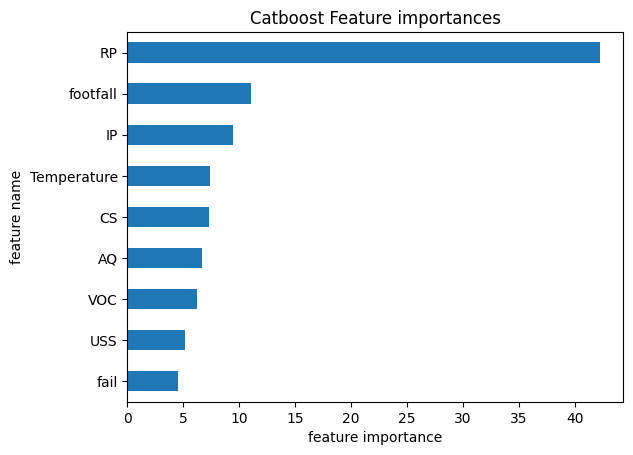

In [25]:
feature_imp = best_cbr.feature_importances_
feature_nm = best_cbr.feature_names_
imp_series = pd.Series(feature_imp)
imp_series.index = feature_nm
print(imp_series.sort_values(ascending=False))
print('\n')
imp_series.sort_values().plot(kind='barh',
                              xlabel='feature importance',
                              ylabel='feature name',
                              title='Catboost Feature importances')
plt.show()